# Predicting House Prices

Inspired by [Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard?fbclid=IwAR2njt-MxaSsIJ0zED_VdPdgs_ZdgA_Th8meaOBtjWuS8qMJtzDJ754eo94) and [Laurenstc](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe/notebook?fbclid=IwAR0PHkeKShKgqEJjxXw4_X7FptfMW1Iz59Gi74O-fYqJG_-naQh04oceRZ8)'s kaggle notebooks. A big part of the feature engineering is based on their code. 

* feature engineering
* prediction methods 
* results
* Improvements

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline


In [211]:
test = pd.read_csv("test.csv")
print(len(test))
train = pd.read_csv("train.csv")
print(len(train))

1459
1460


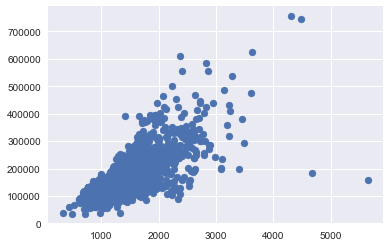

In [212]:
plt.scatter(train["GrLivArea"], train["SalePrice"])
plt.show()

In [213]:
#removing outliers with GrLivArea > 4500 
train = train[train["GrLivArea"]<4500]

In [214]:
len(train["Id"].value_counts()) #unqiue 1458
len(train) #1458

len(test["Id"].value_counts()) #1459
len(test) #1459

#drop id since they are just like the index column 
train = train.drop("Id", axis =1)
test = test.drop("Id", axis = 1)

In [215]:
orginal_index = train["SalePrice"].reset_index(drop = True) 
#drop parameter in reset index aovids the old index being added as a column

In [216]:
df1 = train.drop("SalePrice", axis = 1)
df2 = test

In [217]:
df = pd.concat([df1,df2]).reset_index(drop = True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Data Transformation
* need not transform response variable at least for the moment
* The log or transformation of response y is based on seing heterescedasticrtity in residual plots.
* the histograms of response variables need not be close to normal. The assumption of MLR is that errors are normall distributed with a common variance. 
* this need not emply that the histogram of respones(y) is normall distributed. 
* if there are many similar vectors of x's then the distribution of y;s over this subset with simlar x vectors is close to normal


(array([ 148.,  722.,  372.,  135.,   51.,   19.,    4.,    3.,    2.,    2.]),
 array([  34900.,  106910.,  178920.,  250930.,  322940.,  394950.,
         466960.,  538970.,  610980.,  682990.,  755000.]),
 <a list of 10 Patch objects>)

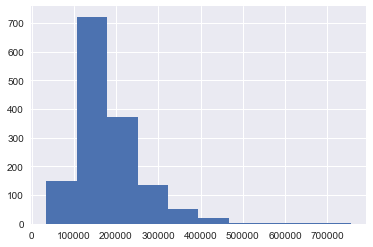

In [218]:
plt.hist(train["SalePrice"])
#right skewed so reponse is not as normal,
#therefore we would observe response distribution later after observing variance 

## Observing Na's

In [219]:
# construct missing ratio 
df_na = df.isnull().sum()*100/len(df)
df_na = df_na.drop(df_na[df_na ==0].index).sort_values(ascending =False)
#len(df_na) # =34
df_na # this is seen as the missing data ratio in the predictor variables

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageFinish     5.450806
GarageYrBlt      5.450806
GarageQual       5.450806
GarageCond       5.450806
GarageType       5.382242
BsmtExposure     2.811107
BsmtCond         2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
BsmtFullBath     0.068564
BsmtHalfBath     0.068564
Utilities        0.068564
Functional       0.068564
Exterior2nd      0.034282
Exterior1st      0.034282
SaleType         0.034282
BsmtFinSF1       0.034282
BsmtFinSF2       0.034282
BsmtUnfSF        0.034282
Electrical       0.034282
KitchenQual      0.034282
GarageCars       0.034282
GarageArea       0.034282
TotalBsmtSF      0.034282
dtype: float64

In [220]:
df["PoolQC"].sort_values()
# We see that there are Ex Fa and Gd
# we can fill all NaN's to None becoming the 4th category
df["PoolQC"] = df["PoolQC"].fillna("None")

In [221]:
#Nan meaning no misc feature 
df["MiscFeature"].sort_values()
#fill with None as 4th category
df["MiscFeature"] = df["MiscFeature"].fillna("None")
#do that for the similar predictor variables
df["Alley"] = df["Alley"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")


In [222]:
# fill the missing values with the median of the data
# since we can assume the linear feet of street connected to the property is similar
# lot frontage: means that portion of a lot that abuts a public or private street. 
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df.groupby("Neighborhood")["LotFrontage"].median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [223]:
df["GarageType"] = df["GarageType"].fillna("None")
df["GarageFinish"] = df["GarageFinish"].fillna("None")
df["GarageQual"] = df["GarageQual"].fillna("None")
df["GarageCond"] = df["GarageCond"].fillna("None")

#fill with 0 since no garage => no cars
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)
df["GarageArea"] = df["GarageArea"].fillna(0)
df["GarageCars"] = df["GarageCars"].fillna(0)

In [224]:
#there are quite a few more nulls we need to fix
nulls = np.sum(df.isnull())
len(nulls[nulls != 0]) # 21 more we need to fix 
nulls[nulls != 0]

MSZoning         4
Utilities        2
Exterior1st      1
Exterior2nd      1
MasVnrType      24
MasVnrArea      23
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
Electrical       1
BsmtFullBath     2
BsmtHalfBath     2
KitchenQual      1
Functional       2
SaleType         1
dtype: int64

In [225]:
#Only 4 missing 
np.sum(df["MSZoning"].isnull())
df["MSZoning"].value_counts()
#lets just fill the na's with RL since it is the most common 
df["MSZoning"] = df["MSZoning"].fillna("RL")

In [226]:
#Most common value is TA since only 1 observation is missing lets use it to fill the NaN
df["KitchenQual"].value_counts()
df["KitchenQual"] =df["KitchenQual"].fillna("SBrkr")

In [227]:
#This does not help since the data is unbalance, may mess up training and holdout 
df["Utilities"].value_counts()
df = df.drop(['Utilities'], axis=1)

In [228]:
#Since only missing 1 observation fill with most common value
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

In [229]:
df["MasVnrType"].value_counts()

None       1742
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [230]:
#Na meaning no masonry veneer fill None and 0 
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

# Basement related variables

In [231]:
#In this case the missing values suggest that there is not basement 
nulls = np.sum(df.isnull())
nulls[nulls != 0]

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
Electrical       1
BsmtFullBath     2
BsmtHalfBath     2
Functional       2
SaleType         1
dtype: int64

In [232]:
#we fill with 0
for i in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[i] = df[i].fillna(0)

In [233]:
#Observe the basement related columns
df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF']].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,Gd,TA,No,GLQ,Unf,706.0,0.0,150.0,856.0
1,Gd,TA,Gd,ALQ,Unf,978.0,0.0,284.0,1262.0
2,Gd,TA,Mn,GLQ,Unf,486.0,0.0,434.0,920.0
3,TA,Gd,No,ALQ,Unf,216.0,0.0,540.0,756.0
4,Gd,TA,Av,GLQ,Unf,655.0,0.0,490.0,1145.0


In [234]:
#NaN in this case would mean no basement so we replace with none
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[i] = df[i].fillna('None')

# Electrical, Functional and SaleType varialbe

In [235]:
nulls = np.sum(df.isnull())
nulls[nulls != 0]
#each of these aren't missing much data 

Electrical    1
Functional    2
SaleType      1
dtype: int64

In [236]:
#since the electrical variable is only missing one observation we will replace with the most common observation,
#which is "SBrkr"
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

#As in the data description NA means Typical, which is Typ
df["Functional"] = df['Functional'].fillna("Typ")

#Fill in with the most frequent SaleType since only missing one observation
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

In [237]:
nulls = np.sum(df.isnull())
nulls[nulls != 0]
#We have filled in all the NA's 

Series([], dtype: int64)

In [238]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'O

# Change Numerical variables to Categorical

In [239]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)



In [240]:
# Create new variable as total are of the house, which is just summing up the basement, 1st, and 2nd floor.
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [241]:
from sklearn.preprocessing import LabelEncoder
variables = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for v in variables:
    labels = LabelEncoder() 
    labels.fit(list(df[v].values)) 
    df[v] = labels.transform(list(df[v].values))

# shape        
print('Shape all_data: {}'.format(df.shape))


#Encode labels for future prediction use of categorical variables

Shape all_data: (2917, 79)


# Back to Train and Test set

In [255]:
train_cleaned = df[:len(train)]
holdout = df[len(train):]

# Add the price column back on the train set

In [257]:
train_cleaned["SalePrice"] = train["SalePrice"]

/Users/chi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [260]:
train_cleaned.to_csv("train_cleaned.csv", index = False)

In [261]:
holdout.to_csv("test_cleaned.csv", index = False)